In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [3]:
df = pd.read_excel("../input/weather-cond2/4_year_df.xlsx", engine="openpyxl")

In [4]:
df.head()

,Homérséklet,Páratartalom,Légnyomás,minute_sin,month_cos,hour_sin,hour_cos,month_sin,day_sin,day_cos
0,0.7,74,1029.7,8.183028e-01,0.866025,0.000000,1.000000,0.5,0.207912,0.978148
1,1.4,75,1029.6,5.322217e-02,0.866025,0.000000,1.000000,0.5,0.207912,0.978148
2,1.6,75,1029.8,-9.996456e-01,0.866025,0.000000,1.000000,0.5,0.207912,0.978148
3,1.9,75,1029.7,-2.449294e-16,0.866025,0.000000,1.000000,0.5,0.207912,0.978148
4,1.7,77,1029.8,8.993121e-01,0.866025,0.269797,0.962917,0.5,0.207912,0.978148


In [5]:
df.shape

(128829, 10)

In [6]:
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df)

scaled_df

array([[0.01842105, 0.675     , 0.70719178, ..., 0.75      , 0.60452846,
        0.9890738 ],
       [0.03684211, 0.6875    , 0.70547945, ..., 0.75      , 0.60452846,
        0.9890738 ],
       [0.04210526, 0.6875    , 0.70890411, ..., 0.75      , 0.60452846,
        0.9890738 ],
       ...,
       [0.22631579, 0.6625    , 0.42123288, ..., 0.5       , 0.60452846,
        0.9890738 ],
       [0.22105263, 0.675     , 0.41952055, ..., 0.5       , 0.60452846,
        0.9890738 ],
       [0.21315789, 0.675     , 0.42123288, ..., 0.5       , 0.60452846,
        0.9890738 ]])

In [7]:
class WeatherDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [8]:
def create_sequences(data, input_length, output_length):

    sequences_x = []
    sequences_y = []
    for i in range(len(data)-input_length-output_length+1):
        sequences_x.append(data[i:i+input_length])
        sequences_y.append(data[i+input_length:i+input_length+output_length,0]) #It only should use the first column

    return np.array(sequences_x), np.array(sequences_y)

In [9]:
input_length = 700
output_length = 300

sequences_x, sequences_y = create_sequences(scaled_df, input_length, output_length)

In [10]:
class LSTM_weather(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, seq_length, output_length):
        super(LSTM_weather, self).__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.output_length = output_length

        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        out = output[:, -self.output_length:, :]

        out = self.relu(self.fc(out))



        return out

In [11]:
def train_val_split(sequences_x, sequences_y, val_percentage):
    val_size = int(val_percentage*len(sequences_x)/100)
    val_x, train_x = sequences_x[:val_size], sequences_x[val_size:]
    val_y, train_y = sequences_y[:val_size], sequences_y[val_size:]

    return train_x, val_x, train_y,  val_y


In [12]:
val_percentage = 25
x_train, x_val, y_train, y_val = train_val_split(sequences_x, sequences_y, val_percentage)

In [13]:
train_dataset = WeatherDataset(torch.tensor(x_train, dtype = torch.float32).to(device), torch.tensor(y_train, dtype = torch.float32).to(device))
val_dataset = WeatherDataset(torch.tensor(x_val, dtype = torch.float32).to(device), torch.tensor(y_val, dtype = torch.float32).to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, drop_last=True)

In [14]:
#the hyperparameters were optimized out
input_dim = 10
hidden_size = 312
num_layers = 1
seq_length = 700
output_length = 300

model = LSTM_weather(input_dim, hidden_size, num_layers, seq_length, output_length).to(device)

criterion = nn.MSELoss()


learning_rate = 0.0011357775426126904

optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [15]:
def plotting_loss(epochs, train_loss, val_loss):

  plt.plot(epochs, train_loss, color = 'b', label = 'Training Loss')
  plt.plot(epochs, val_loss, color = 'g', label = 'Validation Loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title('Summed up loss over Epochs')
  plt.legend()
  plt.grid(True)
  plt.savefig('/kaggle/working/final_model_loss_epoch_fig.png')

  plt.show()
  


In [16]:
def save_checkpoint(model, optimizer, epochs, train_loss, val_loss):

  save_path = '/kaggle/working/final_model_end_checkpoint.pth'

  checkpoint = {
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'epochs': epochs,
      'train_loss': train_loss,
      'val_loss': val_loss,
  }
  torch.save(checkpoint, save_path)

In [17]:
def load_checkpoint(model, optimizer):

  file_path = '/kaggle/working/final_model_end_checkpoint.pth'
  checkpoint = torch.load(file_path)

  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model, optimizer

Starting Training...
Epoch: 1, Training loss: 0.05125239388215995, Validation loss: 0.043411895261801225
Epoch: 2, Training loss: 0.04174647228106874, Validation loss: 0.03751422396608123
Epoch: 3, Training loss: 0.03610321229955714, Validation loss: 0.03219101337491085
Epoch: 4, Training loss: 0.03090987350825576, Validation loss: 0.027360008521386252
Epoch: 5, Training loss: 0.02620982626776021, Validation loss: 0.023102179843650567
Epoch: 6, Training loss: 0.022143975242031103, Validation loss: 0.01956099541652537
Epoch: 7, Training loss: 0.01885042517683475, Validation loss: 0.016838995943486108
Epoch: 8, Training loss: 0.016380955237747283, Validation loss: 0.01492799903459302
Epoch: 9, Training loss: 0.01467047404447037, Validation loss: 0.013702787093086567
Epoch: 10, Training loss: 0.013564621323554245, Validation loss: 0.012972153395223982
Epoch: 11, Training loss: 0.012856880431678966, Validation loss: 0.012521550011725906
Epoch: 12, Training loss: 0.01237237188782921, Valida

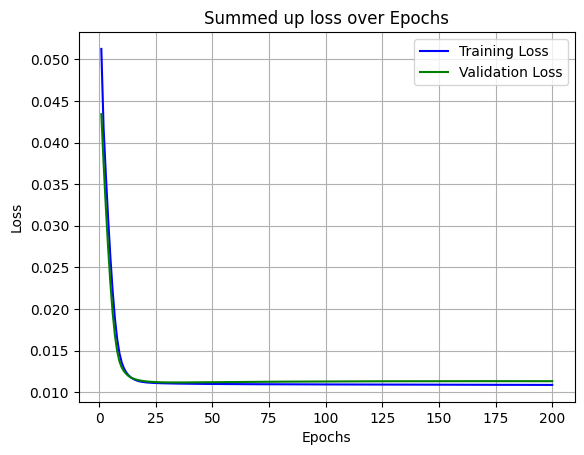

In [18]:
print("Starting Training...")


val_loss = []
train_loss = []
epochs = []

best_val_loss = float("inf")
best_model_weights = None

num_epochs = 200

for epoch in range(0,num_epochs):
    epochs.append(epoch+1)

    train_loss1 = 0
    val_loss1 = 0

    model.train()
    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()

        output_value = model(x_batch)

        loss = criterion(output_value.squeeze(-1), y_batch)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 4.0)

        optimizer.step()

        train_loss1 += loss.item()

        
    train_loss1 /= len(train_loader) #taking the average
    train_loss.append(train_loss1)

    model.eval()
    with torch.no_grad():
        for x_val_batch, y_val_batch in val_loader:

            output_value_val = model(x_val_batch)

            loss_val = criterion(output_value_val.squeeze(-1), y_val_batch)

            val_loss1 += loss_val.item()

            
    val_loss1 /= len(val_loader) #taking the average
    val_loss.append(val_loss1)

    print(f'Epoch: {epoch+1}, Training loss: {train_loss1}, Validation loss: {val_loss1}')

    torch.save(model.state_dict(), f'/kaggle/working/final_model_weights_{epoch+1}_epoch.pth')


    save_checkpoint(model, optimizer, epochs, train_loss, val_loss)
    
    if val_loss1 < best_val_loss:
        best_val_loss = val_loss1
        best_model_weights = model.state_dict()

    
best_epoch = val_loss.index(min(val_loss)) + 1

print(f"The best performing epoch by validation loss: {best_epoch}")


plotting_loss(epochs, train_loss, val_loss)

In [19]:
model.load_state_dict(best_model_weights)

torch.save({
    'model_state_dict': best_model_weights,
    'input_dim': input_dim,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'seq_length': seq_length,
    'output_length': output_length
}, '/kaggle/working/best_model.pth')